In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
from icedef import statoil_arcticnet_data as sd
from icedef import plot, metocean
from importlib import reload
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plot_dir = './plots/'

# BEACON

In [2]:
df_by_id = {}
for beacon_csv_filename in sd.beacon_csv_filenames:
    df = sd.get_beacon_df(sd.beacon_dir_path + beacon_csv_filename)
    beacon_id = df['BeaconID'][0]
    df_by_id[beacon_id] = df

In [3]:
latlons = []
labels = []

for beacon_id, df in df_by_id.items():
    lats, lons = df['Latitude'].values, df['Longitude'].values
    latlons.append([lats, lons])
    labels.append(beacon_id)

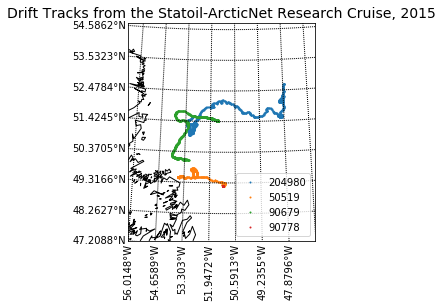

In [4]:
title = 'Drift Tracks from the Statoil-ArcticNet Research Cruise, 2015'
pads = 2
sizes = 2
map_kwargs = {'pads': pads}
scatter_kwargs = {}
kwargs ={'labels': labels, 'title': title, 'map_kwargs': map_kwargs, 'scatter_kwargs': scatter_kwargs}
fig, ax = plot.plot_track(*latlons, **kwargs)
fig.savefig(plot_dir + 'beacon_drift_tracks.png')

Initially, there were two iceberg's -- each with two beacon's attached. One iceberg, which we will call, "iceberg 1" had the beacon's: 50519 and 90778, the other, which we will call, "iceberg 2", had the beacon's 204980 and 90679. The beacon's onboard iceberg 1 were initially attached around 7 PM on April 23rd, 2015; however, after just one hour, beacon 90778 fell off leaving just beacon 50519 onboard iceberg 1 where it remained until around 2 PM on June 1st of that same year. Iceberg 2, on the other hand, has a more interesting life story. On April 24th, 2015 around 3 PM, both beacon's (204980 and 90679) were installed aboard iceberg 2. However, at around TODO, iceberg 2 split forming what we will call iceberg's 3 and 4 with beacon's 204980 and 90670; respectively. When this occurred, iceberg 2 was travelling roughly due West but after the split, iceberg 3 began moving Southwest and iceberg 4 went Northwest. Unfortunately, there is no data on the individual sizes of these bergs.

In [5]:
stats_df = pd.DataFrame(columns=['beacon_id', 'start_time', 'end_time', 'time_length', 
                                 'start_latitude', 'start_longitude',
                                 'end_latitude', 'end_longitude'])
for beacon_id, df in df_by_id.items():
    start_time = df['DataDate_UTC'][0]
    end_time = df['DataDate_UTC'][len(df['DataDate_UTC']) - 1]
    start_lat = df['Latitude'][0]
    end_lat = df['Latitude'][len(df['Latitude']) - 1]
    start_lon = df['Longitude'][0]
    end_lon = df['Longitude'][len(df['Longitude']) - 1]
    stats_df.loc[len(stats_df)] = [beacon_id, start_time, end_time, end_time - start_time, 
                                   start_lat, start_lon, end_lat, end_lon]

In [6]:
stats_df

,beacon_id,start_time,end_time,time_length,start_latitude,start_longitude,end_latitude,end_longitude
0,204980,2015-04-24 15:16:06,2015-06-13 09:33:42,49 days 18:17:36,51.45991,-51.55144,52.69404,-47.82604
1,50519,2015-04-23 18:48:37,2015-06-01 02:09:54,38 days 07:21:17,49.22403,-51.25820,49.46962,-53.58547
2,90679,2015-04-24 15:21:03,2015-05-25 01:20:03,30 days 09:59:00,51.46240,-51.55285,50.09155,-53.06512
3,90778,2015-04-23 18:53:57,2015-04-23 19:57:39,0 days 01:03:42,49.22347,-51.25890,49.22226,-51.24820


# Subset Info

In [7]:
time_bounds = np.datetime64(min(stats_df['start_time'])), np.datetime64(max(stats_df['end_time']))
longitude_bounds = -55, -40
bounds_by_colname = {'time': time_bounds, 'longitude': longitude_bounds}

In [8]:
def subset_ds(ds, bounds_by_colname):
    for colname, bounds in bounds_by_colname.items():
        ds = ds.where((ds[colname] >= bounds[0]) & (ds[colname] <= bounds[1]), drop=True)
    return ds

# AVOS

In [9]:
avos_df = sd.get_avos_df()
avos_ds = sd.get_avos_ds()
avos_ds_subset = subset_ds(avos_ds, bounds_by_colname)

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:54: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


In [10]:
# Note this takes really long to run
#plot.plot_track([avos_df['latitude'].values, avos_df['longitude'].values])

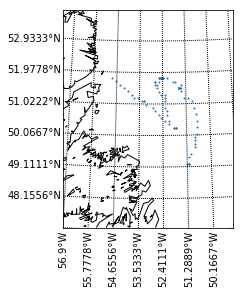

In [11]:
pads = 2
map_kwargs = {'pads': pads}
kwargs = {'map_kwargs': map_kwargs}
fig, ax = plot.plot_track([avos_ds_subset['latitude'].values, avos_ds_subset['longitude'].values], **kwargs)

Note: the ship went back to port after they placed the beacons. It then stayed in port from 2015-05-05 23:00 until 2015-07-10 00:00. 

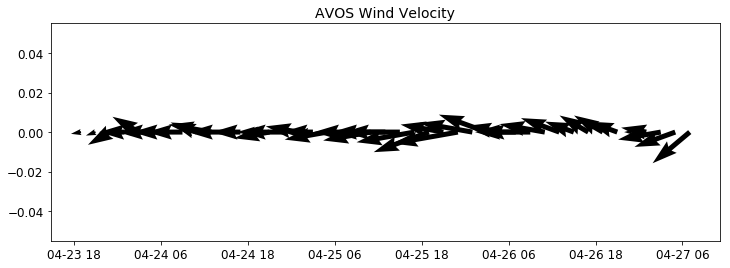

In [12]:
fig = plt.figure(figsize=(12, 4))
gap = 2
len_ = len(avos_ds_subset.time.values[::gap])
x = avos_ds_subset.time.values[::gap]
y = [0] * len_
u = avos_ds_subset.eastward_velocity.values[::gap]
v = avos_ds_subset.northward_velocity.values[::gap]
plt.quiver(x, y, u, v)
plt.title('AVOS Wind Velocity')
plt.show()
fig.savefig(plot_dir + 'avos_wind_velocity.png')

In [13]:
narr_atm = metocean.Atmosphere((avos_ds_subset.time.values[0], avos_ds_subset.time.values[-1]))

In [14]:
narr_atm_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
len_ = len(avos_ds_subset.time.values)
for i in range(len_):
    t = avos_ds_subset.time[i].values
    x = avos_ds_subset.longitude[i].values
    y = avos_ds_subset.latitude[i].values
    u = avos_ds_subset.eastward_velocity[i].values
    v = avos_ds_subset.northward_velocity[i].values
    if np.isfinite(u):
        if np.isfinite(v):
            if -60 <= x <= -40:    
                if 40 <= y <= 60:
                    iu, iv = narr_atm.wind.interpolate((t, y, x))
                    narr_atm_df.loc[len(narr_atm_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

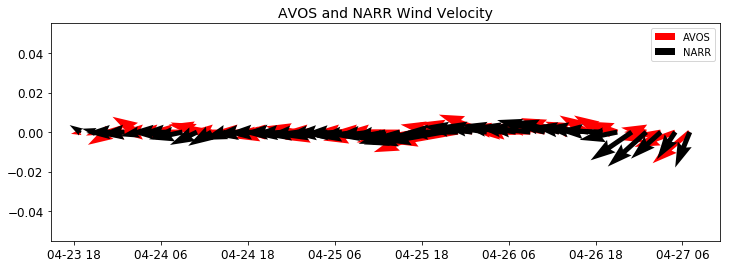

In [15]:
fig = plt.figure(figsize=(12, 4))
gap = 2
len_ = len(avos_ds_subset.time.values[::gap])
x = avos_ds_subset.time.values[::gap]
y = [0] * len_
u = avos_ds_subset.eastward_velocity.values[::gap]
v = avos_ds_subset.northward_velocity.values[::gap]
iu = narr_atm_df.iu.values[::gap]
iv = narr_atm_df.iv.values[::gap]
plt.quiver(x, y, u, v, color='red', label='AVOS')
plt.quiver(x, y, iu, iv, label='NARR')
plt.title('AVOS and NARR Wind Velocity')
plt.legend()
plt.show()
fig.savefig(plot_dir + 'avos_narr_wind_velocity.png')

# ADCP

In [16]:
adcp_ds = sd.get_adcp_ds()

In [17]:
adcp_ds_subset = subset_ds(adcp_ds, bounds_by_colname)

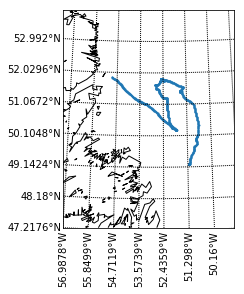

In [18]:
pads = 2
map_kwargs = {'pads': pads}
kwargs = {'map_kwargs': map_kwargs}
fig, ax = plot.plot_track([adcp_ds_subset.latitude.values, adcp_ds_subset.longitude.values], **kwargs)

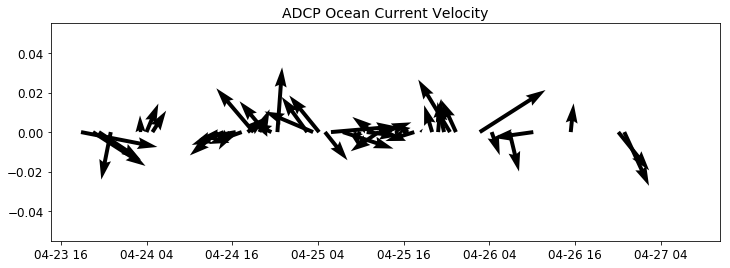

In [19]:
fig = plt.figure(figsize=(12, 4))
gap = 10
len_ = len(adcp_ds_subset.time.values[::gap])
x = adcp_ds_subset.time.values[::gap]
y = [0] * len_
u = adcp_ds_subset.eastward_velocity.values[::gap, 0] 
v = adcp_ds_subset.northward_velocity.values[::gap, 0]
plt.quiver(x, y, u, v)
plt.title('ADCP Ocean Current Velocity')
plt.show()
fig.savefig(plot_dir + 'adcp_current_velocity.png')

In [20]:
time_frame = adcp_ds_subset.time.values[0], adcp_ds_subset.time.values[-1]
ecmwf_ocean = metocean.Ocean(time_frame, model='ECMWF')
hycom_ocean = metocean.Ocean(time_frame, model='HYCOM')

In [21]:
ecmwf_ocean_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
hycom_ocean_df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])

len_ = len(adcp_ds_subset.time.values)
for i in range(len_):
    t = adcp_ds_subset.time.values[i]
    x = adcp_ds_subset.longitude.values[i]
    y = adcp_ds_subset.latitude.values[i]
    u = adcp_ds_subset.eastward_velocity.values[i, 0]
    v = adcp_ds_subset.northward_velocity.values[i, 0]
    if np.isfinite(u):
        if np.isfinite(v):
            if -60 <= x <= -40:    
                if 40 <= y <= 60:
                    iu, iv = ecmwf_ocean.current.interpolate((t, y, x))
                    ecmwf_ocean_df.loc[len(ecmwf_ocean_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]
                    iu, iv = hycom_ocean.current.interpolate((t, y, x))
                    hycom_ocean_df.loc[len(hycom_ocean_df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

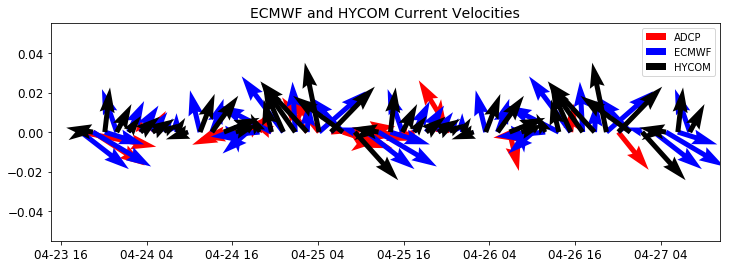

In [22]:
fig = plt.figure(figsize=(12, 4))
gap = 20
len_ = len(adcp_ds_subset.time.values[::gap])
x = adcp_ds_subset.time.values[::gap]
y = [0] * len_
u = adcp_ds_subset.eastward_velocity.values[::gap, 0]
v = adcp_ds_subset.northward_velocity.values[::gap, 0]
plt.quiver(x, y, u, v, color='red', label='ADCP')
iu = ecmwf_ocean_df.iu.values[::gap]
iv = ecmwf_ocean_df.iv.values[::gap]
plt.quiver(x, y, iu, iv, color='blue', label='ECMWF')
iu = hycom_ocean_df.iu.values[::gap]
iv = hycom_ocean_df.iv.values[::gap]
plt.quiver(x, y, iu, iv, label='HYCOM')
plt.title('ECMWF and HYCOM Current Velocities')
plt.legend()
plt.show()
fig.savefig(plot_dir + 'ecmwf_hycom_current_velocity.png')

# AVOS and ADCP

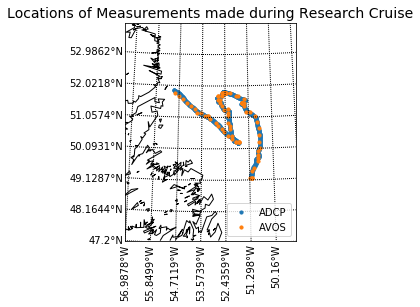

In [23]:
title = 'Locations of Measurements made during Research Cruise'
pads = 2
labels = ['ADCP', 'AVOS']
map_kwargs = {'pads': pads}
sizes = 10
scatter_kwargs = {}
legend_kwargs = {'loc': 4}

kwargs = {'labels': labels,
          'title': title, 'sizes': sizes,
          'map_kwargs': map_kwargs,
          'scatter_kwargs': scatter_kwargs, 
          'legend_kwargs': legend_kwargs}

fig, ax = plot.plot_track([adcp_ds_subset.latitude.values, adcp_ds_subset.longitude.values],
                          [avos_ds_subset['latitude'].values, avos_ds_subset['longitude'].values], **kwargs)
fig.savefig(plot_dir + 'adcp_avos_location.png')

# Histograms

In [24]:
U1 = avos_ds_subset.eastward_velocity.values
V1 = avos_ds_subset.northward_velocity.values
U2 = narr_atm_df.iu.values
V2 = narr_atm_df.iv.values

In [25]:
def magnitude(u, v):
    return np.sqrt(u**2 + v**2)

def direction(u, v):
    return (np.rad2deg(np.arctan2(v, u)) + 360) % 360

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def alg1(u1, v1, u2, v2):
    
    w1 = np.sqrt(u1**2 + v1**2)
    w2 = np.sqrt(u2**2 + v2**2)
    
    return w2 - w1

def alg2(u1, v1, u2, v2):
    
    du = u2 - u1
    dv = v2 - v1
    
    return np.sqrt(du**2 + dv**2)

def alg3(u1, v1, u2, v2):
    
    d1 = np.rad2deg(np.arctan2(u1, v1))
    d2 = np.rad2deg(np.arctan2(u2, v2))  
    dd = 180 - abs(abs(d1 - d2) - 180)
    
    return dd

def alg4(u1, v1, u2, v2):
    
    du = u2 - u1
    dv = v2 - v1
    dd = np.arctan2(dv, du)
    
    return np.rad2deg(dd)

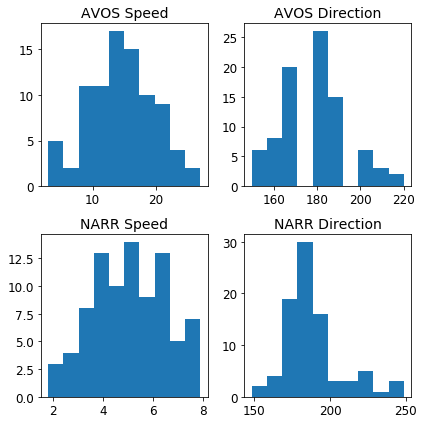

In [26]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.hist(magnitude(U1, V1))
plt.title('AVOS Speed')
plt.subplot(2, 2, 2)
plt.hist(direction(U1, V1))
plt.title('AVOS Direction')
plt.subplot(2, 2, 3)
plt.hist(magnitude(U2, V2))
plt.title('NARR Speed')
plt.subplot(2, 2, 4)
plt.hist(direction(U2, V2))
plt.title('NARR Direction')
fig.tight_layout()
plt.show()

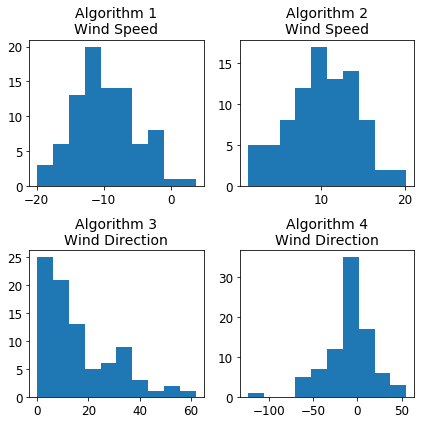

In [27]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.hist(alg1(U1, V1, U2, V2))
plt.title('Algorithm 1\nWind Speed')
plt.subplot(2, 2, 2)
plt.hist(alg2(U1, V1, U2, V2))
plt.title('Algorithm 2\nWind Speed')
plt.subplot(2, 2, 3)
plt.hist(alg3(U1, V1, U2, V2))
plt.title('Algorithm 3\nWind Direction')
plt.subplot(2, 2, 4)
plt.hist(alg4(U1, V1, U2, V2))
plt.title('Algorithm 4\nWind Direction')
fig.tight_layout()
plt.show()

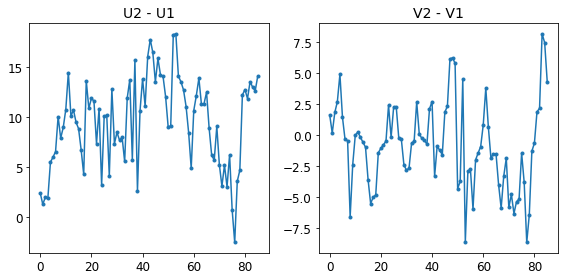

In [33]:
fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(U2 - U1, '.-')
plt.title('U2 - U1')
plt.subplot(1, 2, 2)
plt.plot(V2 - V1, '.-')
plt.title('V2 - V1')
fig.tight_layout()
plt.show()